
Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon


In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold
import pylab

In [2]:
DATA_DIR = '/home/wojtek/Mask'

# Directory to save logs and trained model
# Uwaga! ścieżka nie może zawierać żadnych innych modeli, gdyż powoduje to błędy.
#        Zanim ponownie uruchomisz proces, zmień ją lub usuń jej zawartość.

ROOT_DIR = '/home/wojtek/Mask/output_17_dupa_wielka'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [4]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

### Download COCO pre-trained weights

In [6]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

### Wykorzystanie do uczenia jedynie przypadków Normal oraz Lung Opacity

Należy odkomentować linijkę, żeby użyć w procesie jedynie Normal or Lung Opacity oraz w następnym cell skasować ostatni elif.

In [7]:
df1 = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv')) 
df2 = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_detailed_class_info.csv')) 

#W pliku detailed_class_info są powtarzane te same wiersze(tyle powtórzeń ile bounding box)
df2 = df2.drop_duplicates()
df1 = df1.join(df2.set_index('patientId'), on='patientId')

#df1 = df1.loc[(df1['class'] == 'Lung Opacity') | (df1['class'] == 'Normal')]
df1.head(6)


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  
5                  Lung Opacity

In [8]:
def get_Normal_and_Lung_opacity_dicom_fps(dicom_dir, dataframe):
    
    tmp_counter=0
    tmp_counter2=0
    tmp_counter3=0
    image_fps=[]
    for index, row in dataframe.iterrows():
        if row['class'] == 'Lung Opacity':
            image_fps.append(dicom_dir+'/'+row['patientId']+'.dcm')
            tmp_counter=tmp_counter+1
        elif row['class'] == 'Normal':
            image_fps.append(dicom_dir+'/'+row['patientId']+'.dcm')
            tmp_counter2=tmp_counter2+1
        elif row['class'] == 'No Lung Opacity / Not Normal':
            image_fps.append(dicom_dir+'/'+row['patientId']+'.dcm')
            tmp_counter3=tmp_counter3+1

    print("Liczba Lung Opacity: ")
    print(tmp_counter)
    print("Liczba Normal: ")
    print(tmp_counter2)
    print("Not Normal: ")
    print(tmp_counter3)

    return image_fps

def parse_dataset(dicom_dir, dataframe, image_fps):

    tmp_counter3=0  
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in dataframe.iterrows():
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')   
        image_annotations[fp].append(row)
        tmp_counter3=tmp_counter3+1
    
    print('Łączna liczba danych: ')
    print(tmp_counter3)
         
    return image_annotations 


In [9]:
image_fps=get_Normal_and_Lung_opacity_dicom_fps(train_dicom_dir, dataframe=df1)
image_annotations = parse_dataset(train_dicom_dir, dataframe=df1, image_fps=image_fps)

Liczba Lung Opacity: 
9555
Liczba Normal: 
8851
Not Normal: 
11821
Łączna liczba danych: 
30227


# Ustawienie parametrow - co one znaczają?
- GPU_COUNT - liczba procesorów graficznych GPU
- IMAGES_PER_GPU - liczba zdjęć przypadająca na jeden GPU w czasie uczenia. Jeden 12 GB GPU = 2 x 1024x1024
                 - mój - GTX 1050 2GB
- BACKBONE - dostępne jedynie: resnet50, resnet101
- NUM_CLASSES - liczba class w procesie uczenia. W zadaniu mamy dwie klasy obiektow: tło oraz obszar zmętnienia("zapalenie_pluc")
- IMAGE_MIN_DIM 
- IMAGE_MAX_DIM 
- RPN_ANCHOR_SCALES - prostokąty służące do "wyszukiwania"? kolejne liczby oznaczają rozmiar tych prostokątów

- RPN_ANCHOR_RATIOS - współczynnik boków tych prostokątów. RPN_ANCHOR_RATIOS = [0.5, 1, 2] oznaczaja:     
               -0.5 - prostokąt o 2 razy dłuższym boku pionowym
               -1   - kwadrat
               -2   - prostokąt o 2 razy dłuższym boku poziomym
 Z analizy danych wynika, że są to pionowe obszary.
 
- STEPS_PER_EPOCH - liczba kroków podczas każdej epoki
- TRAIN_ROIS_PER_IMAGE - ???
    Number of ROIs per image to feed to classifier/mask heads
    The Mask RCNN paper uses 512 but often the RPN doesn't generate
    enough positive proposals to fill this and keep a positive:negative
    ratio of 1:3. You can increase the number of proposals by adjusting
    the RPN NMS threshold.
- MAX_GT_INSTANCES - Maksymalna ilość instacji ground truth na zdjęciu
- DETECTION_MAX_INSTANCES - maksymalna liczba instancji wykrywanych na jednym zdjęciu
- DETECTION_MIN_CONFIDENCE - próg pewności 
- DETECTION_NMS_THRESHOLD = non-max suppression (NMS) wybiera jedynie najbardziej dokładne boxy jeżeli wskazują ten sam obiekt
- STEPS_PER_EPOCH - liczba kroków podczas każdej epoki 
    
Więcej informacji o parametrach:
source: https://notebooks.azure.com/versae/projects/mask-rcnn/html/config.py
source: https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py

In [10]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """ 
    NAME = 'pneumonia_XXX'  
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 6   
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    IMAGE_MIN_DIM = 192
    IMAGE_MAX_DIM = 192
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_ANCHOR_RATIOS = [0.4, 0.9, 1.4]
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 2
    DETECTION_MIN_CONFIDENCE = 0.88  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.3
    #(30227-9000)/5/21=202
    STEPS_PER_EPOCH = 120

config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        2
DETECTION_MIN_CONFIDENCE       0.88
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  192
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  192
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [192 192   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [11]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [12]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [13]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [14]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training, validation and test datasets

In [15]:
image_fps_list = list(image_fps)

random.seed(42)
random.shuffle(image_fps_list)

val_size = 6000
test_size = len(image_fps_list)-3000

image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:test_size]
test_image_fps = image_fps_list[test_size:]


print("Train:", len(image_fps_train),"Validation:", len(image_fps_val), "Test:", len(test_image_fps))
print("Przykładowa fps:", image_fps_val[0])

Train: 21227 Validation: 6000 Test: 3000
Przykładowa fps: /home/wojtek/Mask/stage_2_train_images/e925f4f9-e253-4805-8662-583382f74280.dcm


### Create and prepare the training dataset using the DetectorDataset class.

In [16]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [17]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    8c433d4e-8100-4009-9145-1ed9e801f1fe
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 class                                      Normal
 Name: 14107, dtype: object]

In [18]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/home/wojtek/Mask/stage_2_train_images/03edb5ed-9e76-4abe-bc35-7bc95fea7e6a.dcm
[1 1]


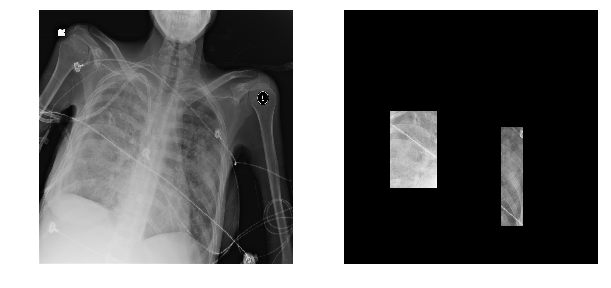

In [19]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

### Augmenters:
- iaa.Fliplr(0.3) - odbijenie lustrzanie 30% wejściowych zdjęć,
- iaa.Affine - przekształcenie afiniczne:
                - skalowanie,
                - translacja,
                - rotate=(-5, 5) ~ obrót w zakresie od -5° do +5°.
- iaa.PiecewiseAffine: transormacje afiniczne, prowadzące do lokalnych zakłóceń,
- iaa.Multiply - mnoży wszystkie piksele obrazu o przez losową wartość z przedziału 0.9-1.1 
- iaa.ContrastNormalization - normalizacja kontrastu, 
- iaa.GaussianBlur - rozmycie przy użycia filtru Gaussa,
- iaa.Sharpen - wyostrzenie obrazu,


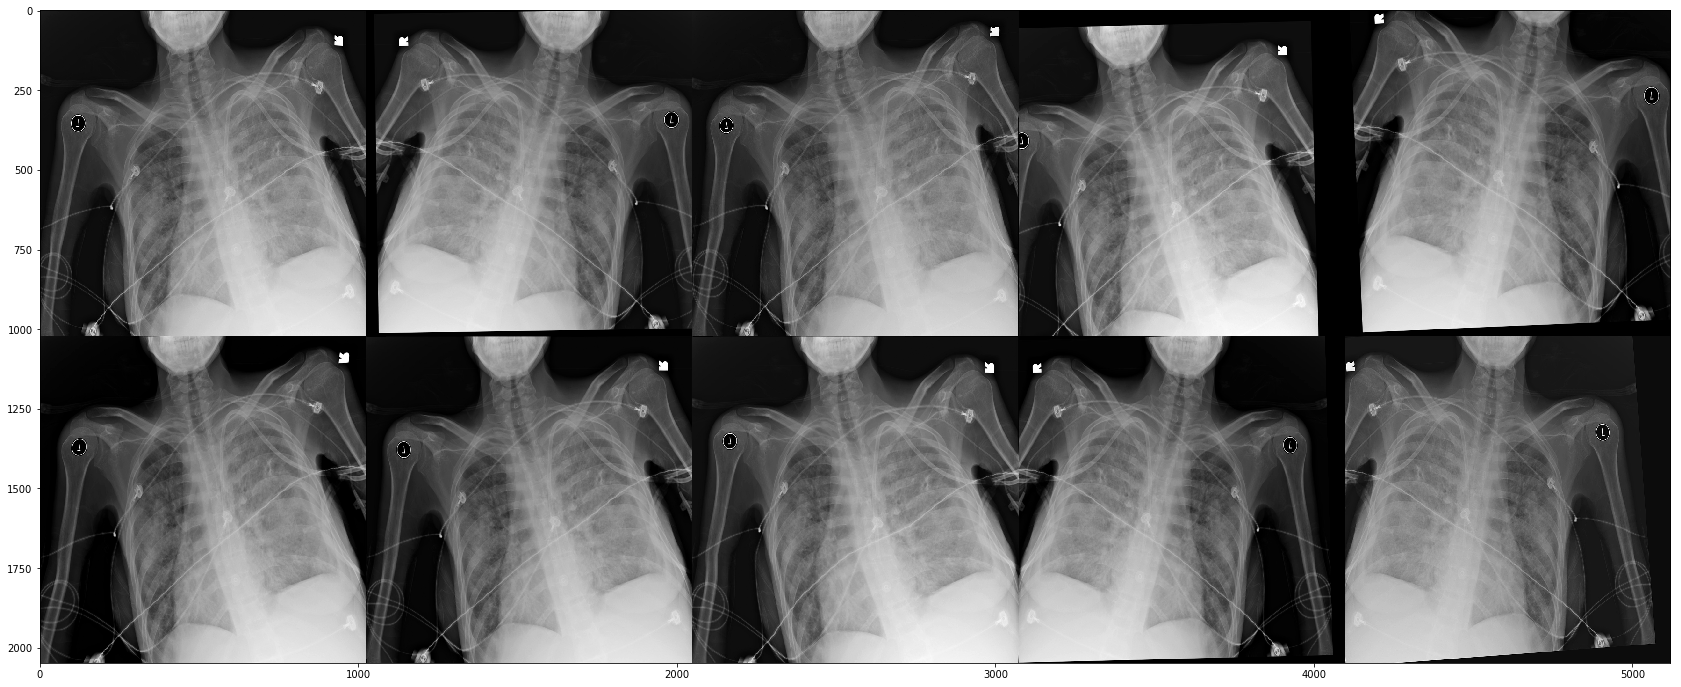

In [20]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.96, 1.06)},
            translate_percent={"x": (-0.10, 0.10), "y": (-0.10, 0.10)},
            rotate=(-5, 5),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.95, 1.15)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Now it's time to train the model.

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN


In [21]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [22]:
LEARNING_RATE = 0.0004

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [23]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*4,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0016

Checkpoint Path: /home/wojtek/Mask/output_17_dupa_wielka/pneumonia_xxx20190301T0249/mask_rcnn_pneumonia_xxx_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       

### Co to wszystko oznacza?
source: https://github.com/matterport/Mask_RCNN/issues/1112

* rpn_class_loss    : wskaźnik pokazujący jak dobrze sieć RPN (Region Proporsal Network) oddziela tło od obiektu

* rpn_bbox_loss    : wskaźnik pokazujący jak dobrze RPN lokalizuje obiekty

* mrcnn_bbox_loss : jak dobrze maska RCNN lokalizuje obiekty

* mrcnn_class_loss : jak dobrze maska RCNN rozpoznaje każdą klasę obiektu

* mrcnn_mask_loss : jak dobrze Mask RCNN oddziela obiekty


In [24]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=8,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.0004

Checkpoint Path: /home/wojtek/Mask/output_17_dupa_wielka/pneumonia_xxx20190301T0249/mask_rcnn_pneumonia_xxx_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b

In [25]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/100,
            epochs=18,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 8. LR=4e-06

Checkpoint Path: /home/wojtek/Mask/output_17_dupa_wielka/pneumonia_xxx20190301T0249/mask_rcnn_pneumonia_xxx_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

120/120 [==============================] - 128s 1s/step - loss: 1.5356 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.4594 - mrcnn_mask_loss: 0.4174 - val_loss: 1.4180 - val_rpn_class_loss: 0.0305 - val_rpn_bbox_loss: 0.3202 - val_mrcnn_class_loss: 0.1978 - val_mrcnn_bbox_loss: 0.4633 - val_mrcnn_mask_loss: 0.4062
CPU times: user 16min 21s, sys: 2min 45s, total: 19min 6s
Wall time: 23min 28s


In [26]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/1000,
            epochs=28,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 18. LR=4.0000000000000003e-07

Checkpoint Path: /home/wojtek/Mask/output_17_dupa_wielka/pneumonia_xxx20190301T0249/mask_rcnn_pneumonia_xxx_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNor

ResourceExhaustedError: OOM when allocating tensor with shape[192,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_3/SGD/gradients/mrcnn_mask/convolution_grad/Conv2DBackpropInput}} = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@training_3/SGD/gradients/mrcnn_mask/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_3/SGD/gradients/mrcnn_mask/convolution_grad/Conv2DBackpropInput-0-VecPermuteNHWCToNCHW-LayoutOptimizer, mrcnn_mask/kernel/read, training_3/SGD/gradients/mrcnn_mask/Sigmoid_grad/SigmoidGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node training_3/SGD/gradients/mrcnn_mask_conv1/convolution_grad/Conv2DBackpropInput-0-0-TransposeNCHWToNHWC-LayoutOptimizer/_8993}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_13501...tOptimizer", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [27]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  val_rpn_bbox_loss  val_mrcnn_class_loss  \
1   1.713415            0.044356           0.404223              0.325340   
2   1.581448            0.033893           0.320100              0.290501   
3   1.532358            0.033553           0.400100              0.231613   
4   1.519395            0.026339           0.458487              0.186321   
5   1.758558            0.049248           0.496863              0.247379   
6   1.478880            0.027086           0.453995              0.155704   
7   2.052123            0.048749           0.989589              0.160534   
8   1.514885            0.026065           0.425443              0.197083   
9   1.444559            0.031975           0.402639              0.205952   
10  1.297433            0.021499           0.329103              0.184402   
11  1.549530            0.030449           0.565867              0.166764   
12  1.384249            0.023533           0.354183              0.189347   
13  1.529989            0.037857           0.499338              0.165935   
14  1.431523            0.023511           0.372609              0.199119   
15  1.274324            0.024306           0.255940              0.206301   
16  1.524892            0.030701           0.359910              0.232914   
17  1.447794            0.023033           0.354130              0.231165   
18  1.418030            0.030461           0.320177              0.197831   

    val_mrcnn_bbox_loss  val_mrcnn_mask_loss      loss  rpn_class_loss  \
1              0.532611             0.406884  1.555631        0.055465   
2              0.547699             0.389253  1.404868        0.040203   
3              0.455589             0.411496  1.321015        0.029250   
4              0.473471             0.374771  1.269663        0.027536   
5              0.553408             0.411653  1.326538        0.025941   
6              0.440718             0.401370  1.309634        0.029748   
7              0.448113             0.405132  1.266268        0.025237   
8              0.449968             0.416318  1.294542        0.024549   
9              0.413516             0.390471  1.277168        0.020890   
10             0.398169             0.364253  1.292148        0.023057   
11             0.411988             0.374456  1.255682        0.023469   
12             0.415127             0.402053  1.157775        0.023659   
13             0.418610             0.408243  1.142315        0.021104   
14             0.429439             0.406838  1.029483        0.016567   
15             0.410240             0.377529  1.450194        0.026550   
16             0.495494             0.405866  1.543652        0.030576   
17             0.443869             0.395590  1.426950        0.025777   
18             0.463311             0.406243  1.535568        0.030534   

    rpn_bbox_loss  mrcnn_class_loss  mrcnn_bbox_loss  mrcnn_mask_loss  
1        0.317601          0.267702         0.482588         0.432274  
2        0.309974          0.249627         0.424146         0.380916  
3        0.292904          0.195438         0.395235         0.408182  
4        0.267656          0.199444         0.377526         0.397494  
5        0.317525          0.210138         0.382619         0.390309  
6        0.247441          0.215741         0.414104         0.402594  
7        0.267464          0.190910         0.380999         0.401652  
8        0.315891          0.196784         0.370057         0.387254  
9        0.275339          0.188429         0.394800         0.397703  
10       0.263157          0.202647         0.399283         0.403998  
11       0.297216          0.185970         0.376091         0.372929  
12       0.232423          0.176682         0.348427         0.376578  
13       0.235022          0.169788         0.340799         0.375596  
14       0.202523          0.164199         0.285277         0.360909  
15       0.377809          0.190415         0.437380 

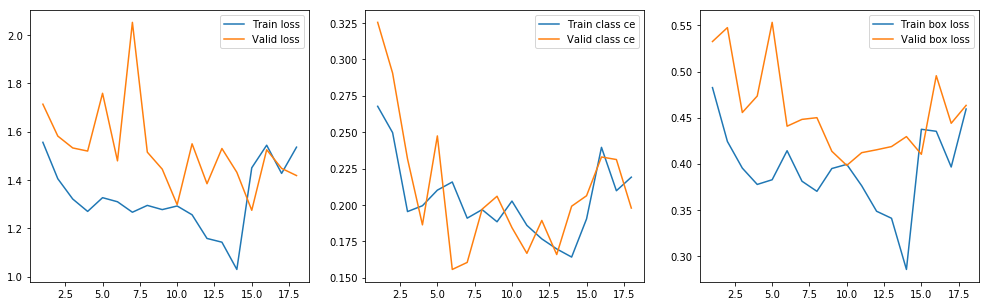

In [28]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

### Overfitting 
training loss << validation loss

### Underfitting
training loss >> validation loss

### Prawidłowa wartość
training loss ~ validation loss


In [29]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 15 1.2743241953849793


In [30]:


# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)


if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        print(len(checkpoints))
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

24
Found model /home/wojtek/Mask/output_17_dupa_wielka/pneumonia_xxx20190301T0249/mask_rcnn_pneumonia_xxx_0015.h5


In [31]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /home/wojtek/Mask/output_17_dupa_wielka/pneumonia_xxx20190301T0249/mask_rcnn_pneumonia_xxx_0015.h5
Re-starting from epoch 15


In [32]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

(192, 192, 3)

*** No instances to display *** 

(192, 192, 3)

*** No instances to display *** 

(192, 192, 3)

*** No instances to display *** 


*** No instances to display *** 

(192, 192, 3)
(192, 192, 3)

*** No instances to display *** 

(192, 192, 3)
(192, 192, 3)

*** No instances to display *** 

(192, 192, 3)

*** No instances to display *** 

(192, 192, 3)

*** No instances to display *** 

(192, 192, 3)


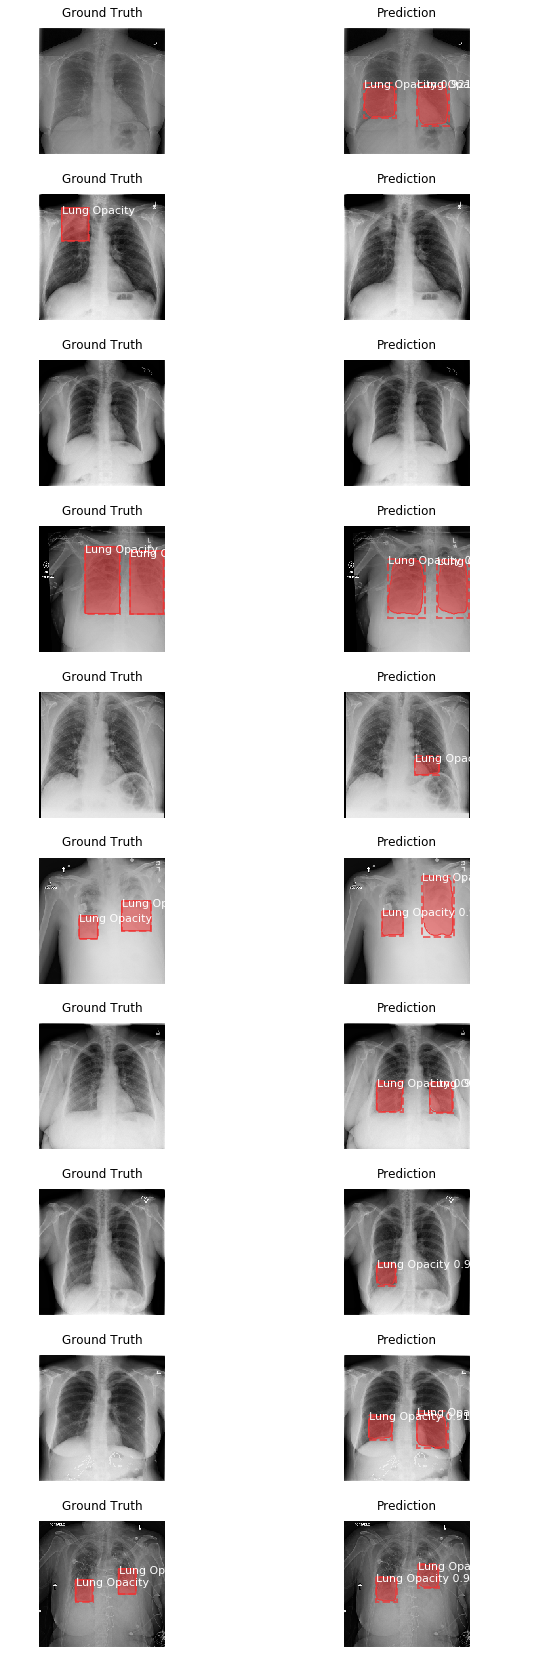

In [33]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(10):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(10, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    plt.title('Ground Truth')
    
    plt.subplot(10, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    plt.title('Prediction')

In [34]:
# Get filenames of test dataset DICOM images
#def get_dicom_fps(dicom_directory):
#    dicom_filepaths = glob.glob(dicom_directory+'/'+'*.dcm')
#    return list(set(dicom_filepaths))

#test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [35]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [36]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [07:01<00:00,  7.26it/s]

/home/wojtek/Mask/output_17_dupa_wielka/submission.csv


In [37]:
output = pd.read_csv(submission_fp)
output.head(60)

patientId  \
0   f8e0ed85-399a-4c57-afc5-a111923d2662   
1   d27b2708-49f7-4bf3-b2e0-56519eee4d5a   
2   3f34c48c-80e6-4a04-9351-6ad809760b70   
3   1321f38d-adb7-491d-97eb-277d57ab6e59   
4   1653174e-bd9e-47f3-a57a-5c5508c3fdc9   
5   100d2b25-aba5-4502-bd2a-edeaa66fde00   
6   9ea70274-1e3d-4fe9-ad36-73334656b134   
7   84c3c816-eb8b-4a44-ae5f-e589011ae9fc   
8   a10735b4-e069-4df3-b1e4-5e54825ebfe1   
9   f5107d16-3da1-4258-8d9a-02e45c3c0d00   
10  4f8808b6-a405-40bb-8d2a-bec9ad4e252e   
11  40e6f86a-3b32-44d8-962b-4302683e123c   
12  de2b7e0d-c5bc-4442-8a98-998e665f3536   
13  7b4c5581-5fd4-476c-b2bb-ee4dcbdf7c71   
14  acd35df7-0450-4696-8e83-df3dd8cb8ecc   
15  7437e61c-7aba-478a-9398-0eed93ba42f5   
16  e8b77cef-4d4e-409c-9674-6c6c3dae8729   
17  7d3b3dd0-2fa5-43dc-a84b-673bc0eebaa7   
18  82a2e069-1e54-45f5-9c96-49cd1d31f661   
19  369b5945-e573-4e49-99e8-dc608604be51   
20  3d62329f-40d2-41e5-bcdd-c7eabc33f516   
21  3b547956-1d00-47b0-8dbb-fe0c40bf6bbf   
22  b87a7ed6-a5d7-42ea-a9d5-d487a2d9108e   
23  c9bd24b1-d36e-47b4-860f-6ee5d5ecb2a6   
24  fde7bf44-9cb7-4506-9738-5774d4547f6f   
25  f09d8288-c4f7-480d-a24d-b1c54c5ede45   
26  654a61e7-07a9-4cb1-855f-a21ecba6fb18   
27  ab155e3a-d8de-4de3-a965-2dd883769073   
28  e0a6d43d-5889-4d2a-a853-3b3234ac8fbb   
29  914a6efd-0a20-4202-9059-12cee1d9643f   
30  9fb2067e-c64c-428e-8c25-7f50c1f3db42   
31  80915b6d-b13b-4506-98b8-73f6c10dc32d   
32  31ba8a38-bc46-4208-9225-f4a6290d7966   
33  6789e4a8-92e1-47df-8b10-d979da39489a   
34  23817810-a792-4c97-a15c-24d3c9da1f3b   
35  7a68a464-daf2-4942-a1e5-80c6c26ab898   
36  4e716933-0a3f-4caa-8364-babe0e4a30d8   
37  adc43a9a-627c-47f8-98dc-e7163b786d0e   
38  afaeb13e-137c-415b-aa87-1f329432aa1c   
39  17e95c76-ae2f-4ad9-b713-08b617d3c9bd   
40  849217ad-5cb2-4a87-9796-420b69722b14   
41  164e8e2e-f90c-41d8-a7ee-cfee6fef16b2   
42  7b621e4e-0f8f-4b7f-8a67-4f1b365d357c   
43  855d0926-1ae6-403e-a08d-85bd8bae4941   
44  e07e0635-2b05-435a-b6db-15dfd081f207   
45  fc4cd513-fc64-44be-aa46-83515c121eee   
46  d667579e-aa2d-461e-a869-4799ad466add   
47  23997b8b-5726-4b2d-bd45-b15fc1c4c2af   
48  3e9ff8ec-edfa-4435-a3ef-898b09b234bc   
49  8c5f7cb0-f287-4221-8e6f-12ec2daa2ae0   
50  38dee97d-933d-48f7-8f77-dbb7bc9b2776   
51  066e0d5c-0f47-425c-aa7f-9003c355086b   
52  a7b5d4ff-840c-4db3-bf4a-d5c71b49f754   
53  66ba8805-6b82-4cf7-9cd7-3e3916ca87df   
54  96c14a9c-2346-4e84-88c9-ad30bd422de8   
55  c7a86f8e-20da-4f75-a2f4-3dc176cf7f23   
56  c348479b-d4d4-4cee-8113-763b803820fb   
57  b55ffbb0-1345-41e9-91be-e9803c438b0a   
58  9d4340fd-9d0a-417b-83bb-3d132f3f9f96   
59  65a80412-256e-4981-b286-9cabcd9ba7e7   

                                     PredictionString  
0    0.99 602.6666666666666 480.0 218.666666666666...  
1    0.97 576.0 384.0 218.66666666666666 218.66666...  
2    0.96 624.0 554.6666666666666 192.0 277.333333...  
3                                                 NaN  
4                                                 NaN  
5                                                 NaN  
6                                                 NaN  
7                                                 NaN  
8            0.97 320.0 336.0 240.0 469.3333333333333  
9                                                 NaN  
10                                                NaN  
11                                                NaN  
12                                                NaN  
13   0.97 240.0 250.66666666666666 234.66666666666...  
14                                                NaN  
15   0.96 645.3333333333333 666.6666666666666 208....  
16                                                NaN  
17   0.96 314.66666666666663 341.3333333333333 250...  
18   0.95 240.0 357.3333333333333 192.0 218.666666...  
19   0.96 688.0 517.3333333333333 240.0 266.666666...  
20                                                NaN  
21                                                NaN  
22                                                NaN  
23

5f4de3de-11c8-4adc-ab78-8b16a0e2be00
[ 44 113 124 163]
x 602 y 234 h 267 w 427
[ 79  38 113  71]
x 202 y 421 h 176 w 181
df2d185c-9107-44ad-ad65-cde2a7a8991b
[111  30 156  74]
x 160 y 592 h 234 w 240
[110 117 153 151]
x 624 y 586 h 181 w 230
7c177034-bb35-44e8-a208-de058a824d64
[102 118 134 153]
x 629 y 544 h 187 w 170
5a18b41e-6e23-4fbe-a55a-ef6cfb027b0d
[ 92  34 123  70]
x 181 y 490 h 192 w 166


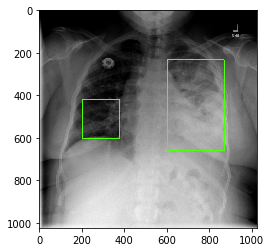

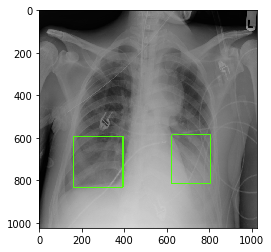

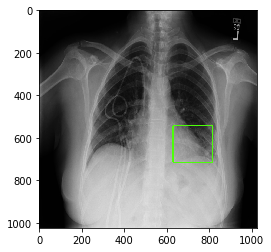

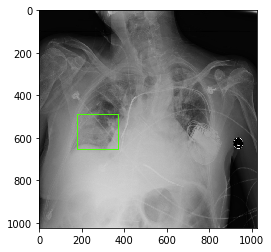

In [38]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

In [39]:
DATA_DIR = '/home/wojtek/Mask'
#ROOT_DIR = '/home/wojtek/Mask/output_5_all_image_192_size'
import csv
import pandas as pd

print('Gdzie head?')
#submission = pd.read_csv(os.path.join(ROOT_DIR, 'submission.csv')).fillna(value = {'PredictionString': 'nie wykryto'})
#pd.read_csv('data.csv').fillna(value = {'a':0,'b':'c','c':3})
#submission.head(n=8)


Gdzie head?


In [40]:
df_labels = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
df_labels.head(n=4)

patientId   x   y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5 NaN NaN    NaN     NaN       0

In [41]:
DATA_DIR = '/home/wojtek/Mask'
#ROOT_DIR = '/home/wojtek/Mask/output_5_all_image_192_size'
import csv
import pandas as pd
import os


df = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv')) 
#for index, row in df.iterrows():
        #if (submission['PredictionString'].iloc[index]) == 'nie wykryto':
            
            
df1.head(7)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  
5                  Lung Opacity  
6  No Lung Opacity / Not Normal

In [42]:
DATA_DIR = '/home/wojtek/Mask'
#ROOT_DIR = '/home/wojtek/Mask/output_5_all_image_192_size'
import csv
import pandas as pd
import os

def create_dictionary(input_path):
    # empty dictionary
    pneumonia_locations = {}
    # load table
    with open(os.path.join(input_path), mode='r') as infile:
        # open reader
        reader = csv.reader(infile)
        # skip header
        next(reader, None)
        # loop through rows
        for rows in reader:
            # retrieve information
            filename = rows[0]
            location = rows[1:5]
            pneumonia = rows[5]
            # if row contains pneumonia add label to dictionary
            # which contains a list of pneumonia locations per filename
            if pneumonia == '1':
                # convert string to float to int
                location = [int(float(i)) for i in location]
                # save pneumonia location in dictionary
                if filename in pneumonia_locations:
                    pneumonia_locations[filename].append(location)
                else:
                    pneumonia_locations[filename] = [location]
    return pneumonia_locations


dictionary = create_dictionary(input_path='/home/wojtek/Mask/stage_2_train_labels.csv')



df1 = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv')) 
df2 = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_detailed_class_info.csv')) 
df3 = pd.read_csv(os.path.join(ROOT_DIR, 'submission.csv')).fillna(value = {'PredictionString': 'nie wykryto'})
print(len(df3))
#W pliku detailed_class_info są powtarzane te same wiersze(tyle powtórzeń ile bounding box)

#df2 = df2.drop_duplicates()
#df3 = df3.join(df1.set_index('patientId'), on='patientId')

df3.head(6)
#print(dictionary)

3000


patientId  \
0  f8e0ed85-399a-4c57-afc5-a111923d2662   
1  d27b2708-49f7-4bf3-b2e0-56519eee4d5a   
2  3f34c48c-80e6-4a04-9351-6ad809760b70   
3  1321f38d-adb7-491d-97eb-277d57ab6e59   
4  1653174e-bd9e-47f3-a57a-5c5508c3fdc9   
5  100d2b25-aba5-4502-bd2a-edeaa66fde00   

                                    PredictionString  
0   0.99 602.6666666666666 480.0 218.666666666666...  
1   0.97 576.0 384.0 218.66666666666666 218.66666...  
2   0.96 624.0 554.6666666666666 192.0 277.333333...  
3                                        nie wykryto  
4                                        nie wykryto  
5                                        nie wykryto

In [43]:
import matplotlib.pyplot as plt
 
def creat_Confusion_matrix_pie_chart(TP, TN, FN, FP):     
    # Data to plot
    labels = 'Prawdziwie pozytywna, TP', 'Prawdziwie negatywna, TN', 'Fałszywie negatywna, FN', 'Fałszywie pozytywna, FP'
    sizes = [TP, TN, FN, FP]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    explode = (0.1, 0, 0, 0)  # explode 1st slice
 
    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)
 
    plt.axis('equal')
    plt.show()

In [44]:
import numpy as np # linear algebra 
from bbox.metrics import jaccard_index_2d
from bbox import BBox2D

### source: https://pypi.org/project/bbox/

def iou_metric(submission, threshold_iou):
    
    FP = 0
    TP = 0
    FN = 0
    TN = 0
    FP_iou = 0

    for index, row in submission.iterrows():
        print(index)
        print( submission['PredictionString'].iloc[index] )
        key = submission['patientId'].iloc[index]
        # Wynik testu - Klasyfikacja pozytywna
        if not (submission['PredictionString'].iloc[index]) == 'nie wykryto':
            tmp = 0 
            # Klasa rzeczywista - stan pozytywny
            if key in dictionary:
                print('Liczba ground-truth bounding boxes: ',len(dictionary[key]))
                for i in dictionary[key]:
                    text = submission['PredictionString'].iloc[index]
                    nums = [float(n) for n in text.split()]
                    box1 = BBox2D([nums[1],nums[2],nums[3], nums[4]])
                    box2 = BBox2D(i)
                    iou = jaccard_index_2d(box1, box2)
                    print('IoU: ', iou)
                    if iou > threshold_iou: 
                        tmp = 1
                    if len(nums)>5:
                        box3 = BBox2D([nums[6],nums[7],nums[8], nums[9]])
                        iou = jaccard_index_2d(box2, box3)
                        print('IoU: ', iou)
                        if iou > threshold_iou:
                            tmp = 1
                if tmp == 1:
                    print('iou wieksze od 0.5')
                    TP = TP + 1
                elif tmp == 0:
                    FP_iou = FP_iou + 1
                
            # Klasa rzeczywista - stan negatywny
            else: 
                FP = FP + 1
                print('Brak w rzeczywistości zapalenia pluc')
        # Wynik testu - Klasyfikacja negatywna
        else:
            if not key in dictionary:
                TN = TN +1
            if key in dictionary:
                FN = FN +1

    return TP, TN, FN, FP, FP_iou
    
TP, TN, FN, FP, FP_iou = iou_metric(submission=df3, threshold_iou=0.5)





0
 0.99 602.6666666666666 480.0 218.66666666666666 277.3333333333333
Brak w rzeczywistości zapalenia pluc
1
 0.97 576.0 384.0 218.66666666666666 218.66666666666666
Brak w rzeczywistości zapalenia pluc
2
 0.96 624.0 554.6666666666666 192.0 277.3333333333333
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.7181305189208528
iou wieksze od 0.5
3
nie wykryto
4
nie wykryto
5
nie wykryto
6
nie wykryto
7
nie wykryto
8
 0.97 320.0 336.0 240.0 469.3333333333333
Liczba ground-truth bounding boxes:  1
IoU:  0.3897153874805547
9
nie wykryto
10
nie wykryto
11
nie wykryto
12
nie wykryto
13
 0.97 240.0 250.66666666666666 234.66666666666666 448.0 0.95 629.3333333333333 234.66666666666666 266.66666666666663 538.6666666666666
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.2734042388613862
IoU:  0.24753886125487712
IoU:  -0.0
14
nie wykryto
15
 0.96 645.3333333333333 666.6666666666666 208.0 234.66666666666666
Brak w rzeczywistości zapalenia pluc
16
nie wykryto
17
 0.96 314.666666666666

nie wykryto
488
nie wykryto
489
nie wykryto
490
 0.97 144.0 357.3333333333333 272.0 293.3333333333333 0.97 618.6666666666666 368.0 186.66666666666666 213.33333333333331
Liczba ground-truth bounding boxes:  1
IoU:  0.7309122104661139
IoU:  -0.0
iou wieksze od 0.5
491
nie wykryto
492
nie wykryto
493
nie wykryto
494
nie wykryto
495
 0.96 624.0 448.0 272.0 368.0
Liczba ground-truth bounding boxes:  1
IoU:  0.34071453030475973
496
 0.96 576.0 469.3333333333333 208.0 144.0
Brak w rzeczywistości zapalenia pluc
497
 0.97 245.33333333333331 229.33333333333331 224.0 485.3333333333333 0.95 576.0 261.3333333333333 282.66666666666663 485.3333333333333
Liczba ground-truth bounding boxes:  2
IoU:  0.8100982738502105
IoU:  -0.0
IoU:  -0.0
IoU:  0.18789595427796227
iou wieksze od 0.5
498
 0.96 736.0 560.0 208.0 208.0
Brak w rzeczywistości zapalenia pluc
499
nie wykryto
500
 0.97 629.3333333333333 554.6666666666666 213.33333333333331 282.66666666666663
Brak w rzeczywistości zapalenia pluc
501
 0.97 421.

Liczba ground-truth bounding boxes:  1
IoU:  -0.0
IoU:  0.5621305011606135
iou wieksze od 0.5
609
nie wykryto
610
nie wykryto
611
nie wykryto
612
 0.97 517.3333333333333 293.3333333333333 245.33333333333331 528.0
Liczba ground-truth bounding boxes:  2
IoU:  0.2519762845849802
IoU:  -0.0
613
 0.97 602.6666666666666 288.0 229.33333333333331 186.66666666666666
Liczba ground-truth bounding boxes:  1
IoU:  0.5757784115127775
iou wieksze od 0.5
614
nie wykryto
615
 0.97 501.3333333333333 240.0 229.33333333333331 512.0 0.97 138.66666666666666 256.0 256.0 442.66666666666663
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.7254065088478916
IoU:  0.8487404662007223
IoU:  -0.0
iou wieksze od 0.5
616
nie wykryto
617
nie wykryto
618
nie wykryto
619
nie wykryto
620
nie wykryto
621
nie wykryto
622
 0.96 709.3333333333333 405.3333333333333 186.66666666666666 176.0
Brak w rzeczywistości zapalenia pluc
623
nie wykryto
624
nie wykryto
625
 0.96 240.0 464.0 213.33333333333331 170.66666666666666
B

IoU:  0.42860559674718957
IoU:  -0.0
1044
nie wykryto
1045
nie wykryto
1046
nie wykryto
1047
 0.96 624.0 597.3333333333333 186.66666666666666 170.66666666666666
Brak w rzeczywistości zapalenia pluc
1048
 0.96 570.6666666666666 480.0 213.33333333333331 160.0 0.96 122.66666666666666 394.66666666666663 250.66666666666666 309.3333333333333
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.6288403338224505
IoU:  0.7192790245626437
IoU:  -0.0
iou wieksze od 0.5
1049
nie wykryto
1050
 0.96 618.6666666666666 538.6666666666666 208.0 234.66666666666666
Brak w rzeczywistości zapalenia pluc
1051
 0.97 650.6666666666666 400.0 234.66666666666666 218.66666666666666 0.96 218.66666666666666 213.33333333333331 277.3333333333333 346.66666666666663
Liczba ground-truth bounding boxes:  1
IoU:  -0.0
IoU:  0.6328211629949646
iou wieksze od 0.5
1052
nie wykryto
1053
 0.97 576.0 192.0 277.3333333333333 544.0
Brak w rzeczywistości zapalenia pluc
1054
nie wykryto
1055
nie wykryto
1056
nie wykryto
1057
ni

1170
 0.96 613.3333333333333 165.33333333333331 282.66666666666663 560.0
Liczba ground-truth bounding boxes:  2
IoU:  0.17548437872150954
IoU:  -0.0
1171
 0.95 629.3333333333333 432.0 186.66666666666666 213.33333333333331
Brak w rzeczywistości zapalenia pluc
1172
nie wykryto
1173
nie wykryto
1174
 0.96 618.6666666666666 506.66666666666663 181.33333333333331 186.66666666666666
Liczba ground-truth bounding boxes:  1
IoU:  -0.0
1175
 0.96 37.33333333333333 165.33333333333331 261.3333333333333 394.66666666666663
Brak w rzeczywistości zapalenia pluc
1176
 0.98 522.6666666666666 229.33333333333331 304.0 576.0
Liczba ground-truth bounding boxes:  2
IoU:  0.6791694357544616
IoU:  -0.0
iou wieksze od 0.5
1177
nie wykryto
1178
nie wykryto
1179
 0.96 597.3333333333333 378.66666666666663 266.66666666666663 314.66666666666663 0.96 240.0 442.66666666666663 202.66666666666666 181.33333333333331
Brak w rzeczywistości zapalenia pluc
1180
nie wykryto
1181
nie wykryto
1182
nie wykryto
1183
nie wykryto
11

1599
nie wykryto
1600
nie wykryto
1601
 0.95 640.0 261.3333333333333 272.0 368.0
Brak w rzeczywistości zapalenia pluc
1602
 0.98 192.0 208.0 320.0 608.0 0.98 608.0 218.66666666666666 288.0 533.3333333333333
Liczba ground-truth bounding boxes:  2
IoU:  0.8209425147267926
IoU:  -0.0
IoU:  -0.0
IoU:  0.7509837938475857
iou wieksze od 0.5
1603
nie wykryto
1604
nie wykryto
1605
 0.96 549.3333333333333 378.66666666666663 186.66666666666666 250.66666666666666
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.23548406839529845
1606
 0.95 533.3333333333333 117.33333333333333 293.3333333333333 416.0
Liczba ground-truth bounding boxes:  2
IoU:  0.003000284574416257
IoU:  0.7791190695382706
iou wieksze od 0.5
1607
 0.97 602.6666666666666 213.33333333333331 245.33333333333331 485.3333333333333
Liczba ground-truth bounding boxes:  1
IoU:  0.7708225501243968
iou wieksze od 0.5
1608
nie wykryto
1609
 0.95 314.66666666666663 512.0 186.66666666666666 176.0
Brak w rzeczywistości zapalenia pluc
16

IoU:  -0.0
IoU:  0.773343565412957
iou wieksze od 0.5
1725
nie wykryto
1726
nie wykryto
1727
nie wykryto
1728
nie wykryto
1729
 0.95 597.3333333333333 250.66666666666666 272.0 490.66666666666663
Liczba ground-truth bounding boxes:  2
IoU:  0.7876025036922423
IoU:  -0.0
iou wieksze od 0.5
1730
nie wykryto
1731
 0.99 330.66666666666663 298.66666666666663 240.0 517.3333333333333 0.98 709.3333333333333 357.3333333333333 261.3333333333333 464.0
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.7250249221344715
IoU:  0.771275327771156
IoU:  -0.0
iou wieksze od 0.5
1732
 0.97 149.33333333333331 672.0 208.0 170.66666666666666
Liczba ground-truth bounding boxes:  1
IoU:  0.45255220853365385
1733
 0.98 202.66666666666666 213.33333333333331 224.0 394.66666666666663 0.97 538.6666666666666 192.0 234.66666666666666 490.66666666666663
Liczba ground-truth bounding boxes:  2
IoU:  0.7749654092479513
IoU:  -0.0
IoU:  -0.0
IoU:  0.8522344325051363
iou wieksze od 0.5
1734
nie wykryto
1735
 0.95 22

 0.95 165.33333333333331 474.66666666666663 234.66666666666666 213.33333333333331
Brak w rzeczywistości zapalenia pluc
2216
nie wykryto
2217
nie wykryto
2218
 0.98 144.0 277.3333333333333 224.0 256.0 0.96 570.6666666666666 298.66666666666663 218.66666666666666 229.33333333333331
Liczba ground-truth bounding boxes:  1
IoU:  0.6989055116182264
IoU:  -0.0
iou wieksze od 0.5
2219
nie wykryto
2220
 0.96 272.0 474.66666666666663 208.0 160.0
Brak w rzeczywistości zapalenia pluc
2221
 0.95 506.66666666666663 192.0 256.0 357.3333333333333
Brak w rzeczywistości zapalenia pluc
2222
 0.97 634.6666666666666 533.3333333333333 202.66666666666666 165.33333333333331
Brak w rzeczywistości zapalenia pluc
2223
nie wykryto
2224
 0.97 256.0 485.3333333333333 186.66666666666666 229.33333333333331 0.97 602.6666666666666 432.0 197.33333333333331 288.0
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.7699261579771761
IoU:  0.6152824090043819
IoU:  -0.0
iou wieksze od 0.5
2225
 0.95 266.66666666666663 6

IoU:  -0.0
IoU:  -0.0
IoU:  0.4124717403684394
iou wieksze od 0.5
2343
nie wykryto
2344
nie wykryto
2345
nie wykryto
2346
nie wykryto
2347
 0.96 736.0 522.6666666666666 160.0 186.66666666666666
Brak w rzeczywistości zapalenia pluc
2348
nie wykryto
2349
 0.95 517.3333333333333 218.66666666666666 240.0 469.3333333333333
Liczba ground-truth bounding boxes:  2
IoU:  0.510404910035538
IoU:  -0.0
iou wieksze od 0.5
2350
nie wykryto
2351
 0.97 58.666666666666664 245.33333333333331 282.66666666666663 357.3333333333333 0.95 480.0 309.3333333333333 282.66666666666663 458.66666666666663
Liczba ground-truth bounding boxes:  2
IoU:  0.4963267281778851
IoU:  -0.0
IoU:  -0.0
IoU:  0.4371850897423121
2352
nie wykryto
2353
 0.95 570.6666666666666 490.66666666666663 170.66666666666666 229.33333333333331
Brak w rzeczywistości zapalenia pluc
2354
 0.98 634.6666666666666 245.33333333333331 245.33333333333331 522.6666666666666 0.98 234.66666666666666 277.3333333333333 277.3333333333333 586.6666666666666
Lic

Liczba ground-truth bounding boxes:  2
IoU:  0.7446253155499789
IoU:  -0.0
IoU:  -0.0
IoU:  0.6071211201559974
iou wieksze od 0.5
2827
 0.96 240.0 544.0 213.33333333333331 144.0
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.4858760636447031
2828
nie wykryto
2829
nie wykryto
2830
nie wykryto
2831
nie wykryto
2832
nie wykryto
2833
nie wykryto
2834
nie wykryto
2835
 0.96 618.6666666666666 522.6666666666666 181.33333333333331 170.66666666666666 0.95 272.0 480.0 186.66666666666666 176.0
Brak w rzeczywistości zapalenia pluc
2836
nie wykryto
2837
nie wykryto
2838
nie wykryto
2839
nie wykryto
2840
nie wykryto
2841
nie wykryto
2842
 0.99 448.0 213.33333333333331 325.3333333333333 608.0 0.99 80.0 245.33333333333331 288.0 560.0
Liczba ground-truth bounding boxes:  2
IoU:  -0.0
IoU:  0.8079065544403817
IoU:  0.7883644303409963
IoU:  -0.0
iou wieksze od 0.5
2843
nie wykryto
2844
nie wykryto
2845
 0.95 634.6666666666666 384.0 170.66666666666666 181.33333333333331
Brak w rzeczywistości za

IoU:  0.6879433222486447
IoU:  -0.0
iou wieksze od 0.5
2967
 0.96 266.66666666666663 517.3333333333333 165.33333333333331 181.33333333333331 0.96 565.3333333333333 490.66666666666663 176.0 186.66666666666666
Brak w rzeczywistości zapalenia pluc
2968
nie wykryto
2969
nie wykryto
2970
nie wykryto
2971
nie wykryto
2972
 0.95 218.66666666666666 544.0 202.66666666666666 192.0
Brak w rzeczywistości zapalenia pluc
2973
 0.96 314.66666666666663 474.66666666666663 213.33333333333331 149.33333333333331
Brak w rzeczywistości zapalenia pluc
2974
 0.95 261.3333333333333 245.33333333333331 250.66666666666666 394.66666666666663
Liczba ground-truth bounding boxes:  3
IoU:  -0.0
IoU:  -0.0
IoU:  0.6195275674563407
iou wieksze od 0.5
2975
nie wykryto
2976
nie wykryto
2977
nie wykryto
2978
 0.95 218.66666666666666 490.66666666666663 197.33333333333331 197.33333333333331
Brak w rzeczywistości zapalenia pluc
2979
 0.98 688.0 426.66666666666663 213.33333333333331 240.0
Brak w rzeczywistości zapalenia pluc
2

In [45]:
print('Predykcja nie wykryła: ')
print("FN: ", FN)
print("TN: ", TN)
print('Predykcja wykryła: ')
print("TP: ", TP)
print("FP: ", FP)
print("FP_iou: ", FP_iou)
print('ALL: ', FN+TN+TP+FP+FP_iou)
accuracy = ( TP + TN )/( TP + TN + FP + FN + FP_iou )
print('Accuracy: ', accuracy)

Predykcja nie wykryła: 
FN:  281
TN:  1440
Predykcja wykryła: 
TP:  454
FP:  619
FP_iou:  206
ALL:  3000
Accuracy:  0.6313333333333333


In [46]:
creat_Confusion_matrix_pie_chart(TP=TP, TN=TN, FN=FN, FP = FP+FP_iou)